In [59]:
import numpy as np
import csv as csv
import pandas as pd

from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import random as random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import losses, metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM

from keras.layers import Dropout
from keras.layers import Bidirectional
#from keras.models import load_model
from tensorflow.keras.models import load_model
import os
from matplotlib import pyplot as plt
#from data_split import data_split
from many_net import many_net_hd_u1d, many_net_1d, many_net_3d_u2d, many_net_uhd

In [60]:
def plot_exponents(data,row,real,predicted):
    fig, ax = plt.subplots()
    real_row= data
    x=[w for w in range(len(data))]
    cp=real['Changepoint'].iloc[row]
    ax.axvline(cp,linestyle='--', color='lightsalmon',label='real')
    ax.axvline(predicted,linestyle='--', color='red',label='predicted')
    ax.legend()
    desviacion=abs(predicted-cp)
    plt.title(f"Window Size 50 Change-Point Prediction")
    ax.text(s = f'Deviation:{str(desviacion)}',x=-15,y=max(real_row)+0.3*max(real_row))
    ax.plot(x,real_row)

In [61]:
def prediccion(enlace,row):
    data = pd.read_csv(enlace)
    real = pd.read_csv("real_ok.csv")
    try:
        data = data.drop(["Unnamed: 0","V1"],axis=1)
        data = data.iloc[row]
    except:
        data = data.iloc[row]
    centersAlfa = [25, 50, 65]
    centersType = [25, 65]
    meta_modelType=[]
    meta_modelAlfa=[]
    for i in centersType:
        m=load_model('task2_1D_recdout_'+str(i)+'.h5')
        meta_modelType.append(m)
    for i in centersAlfa:
        m=load_model('Model_1D_recdout_'+str(i)+'.h5')
        meta_modelAlfa.append(m)
    input_array = data.to_numpy()
    input_array = np.reshape(input_array, newshape=(1,200))
    window_size = 50
    stride = 1
    num_segments = (200 - window_size) // stride + 1
    shape = (1, num_segments, window_size)
    strides = (input_array.strides[0], input_array.strides[1]*stride, input_array.strides[1])
    output_matrix = np.lib.stride_tricks.as_strided(input_array, shape=shape, strides=strides)

    output_array = np.column_stack((np.repeat(np.arange(1), num_segments), output_matrix.reshape(-1, 50)))

    windows = pd.DataFrame(output_array,columns=list(range(-1,50)))

    cols = list(windows.columns) 
    cols[0] = "Trajectory"
    windows.columns = cols
    windowMatrix = windows.to_numpy()
    windowsMatrix_ok = np.delete(windowMatrix,0,1)
    
    "Prediction Part"
    print("Predicting diffusion exponent and diffusion type")
    predictionsAlpha=many_net_hd_u1d(meta_modelAlfa,windowsMatrix_ok,centers=centersAlfa,dim=1)
    predictionsType=many_net_hd_u1d(meta_modelType,windowsMatrix_ok,centers=centersType,dim=1)
    pType = np.reshape(predictionsType[0], newshape=(1,151,5))
    pAlfa = np.reshape(predictionsAlpha[0], newshape=(1,151))
    
    res = []
    for i in range(len(pType)):
        t = []
        for j in range(len(pType[i])):
            a = pType[i][j]
            t.append(int(np.where(a==np.max(a))[0][0]))
        res.append(t)
        
    pdType = pd.DataFrame(res).drop(150,axis=1)
    pdAlfa = pd.DataFrame(pAlfa).drop(150,axis=1)
    pdInput = pd.concat([pdType,pdAlfa],axis=1)
    pdInput.columns = [i for i in range(150)] + ['type'+str(i) for i in range(150)]
    model = keras.models.load_model('final_model.h5')
    predicted = model.predict(pdInput)[0][0]
    plot_exponents(data,row,real,predicted)
    return predicted

Predicting diffusion exponent and diffusion type
1/1 [==============================] - 0s 73ms/step


85.774895

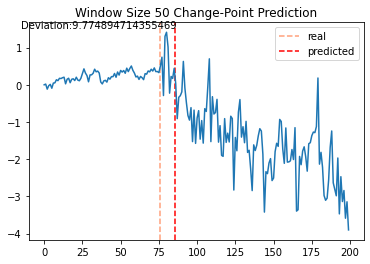

In [62]:
prediccion("task3.csv",0)